In [1]:
import pystan
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
!conda install pystan --y

Solving environment: / 

In [2]:
# For Stan we provide all known quantities as data, namely the observed data
# and our prior hyperparameters.
eczema_data = {
    'treatment': {
        'alpha': 1,  # fixed prior hyperparameters for the
        'beta': 1,   # beta distribution
        'num_trials': 6,  # number of trials in the data set
        'patients': [23, 16, 16, 45, 31, 10],  # number of patients per trial
        'improved': [20, 10, 13, 35, 22, 7]},  # number of improved patients per trial
    'control': {
        'alpha': 1,
        'beta': 1,
        'num_trials': 6,
        'patients': [15, 18, 10, 39, 29, 10],
        'improved': [9, 11, 4, 21, 12, 0]}}

In [2]:
# Below is the Stan code for the medical trial data set. Note that the Stan
# code is a string that is passed to the StanModel object below.

# We have to tell Stan what data to expect, what our parameters are and what
# the likelihood and prior are. Since the posterior is just proportional to
# the product of the likelihood and the prior, we don't distinguish between
# them explicitly in the model below. Every distribution we specify is
# automatically incorporated into the product of likelihood * prior.

stan_code = """

data {  
    int<lower=1> num_trials; 
    int<lower=0> patients[num_trials];  
    int<lower=0> improved[num_trials];  
    real<lower=0> alpha; 
    real<lower=0> beta;  
}

parameters {
    real<lower=0,upper=1> p; 
                             
}

model {
    p ~ beta(alpha, beta); 
    for(i in 1:num_trials) {
        improved[i] ~ binomial(patients[i], p); 
    }
}

"""

In [3]:
stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_09769ca382829dc3c69edd1b863db638 NOW.
/anaconda/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/kg/zv3bhpmx19s5f8hsk7h4_wnc0000gn/T/tmpxi5v2bet/stanfit4anon_model_09769ca382829dc3c69edd1b863db638_1858679541020112532.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


CompileError: command 'gcc' failed with exit status 1

In [6]:
stan_results = stan_model.sampling(data=eczema_data['treatment'])
print(stan_results)

Inference for Stan model: anon_model_4822bea325d0250e03828b3bc1bb8bdd.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
p      0.75  8.8e-4   0.03   0.69   0.73   0.76   0.78   0.82   1509   1.01
lp__ -80.04    0.02   0.66 -81.83 -80.21 -79.79 -79.62 -79.58   1908    1.0

Samples were drawn using NUTS at Mon Oct  8 23:15:07 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [7]:
print(stan_results.stansummary(pars=['p'], probs=[0.025, 0.5, 0.975]))

Inference for Stan model: anon_model_4822bea325d0250e03828b3bc1bb8bdd.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

    mean se_mean     sd   2.5%    50%  97.5%  n_eff   Rhat
p   0.75  8.8e-4   0.03   0.69   0.76   0.82   1509   1.01

Samples were drawn using NUTS at Mon Oct  8 23:15:07 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


Posterior 95% confidence interval for p: [0.68612833 0.81834505]


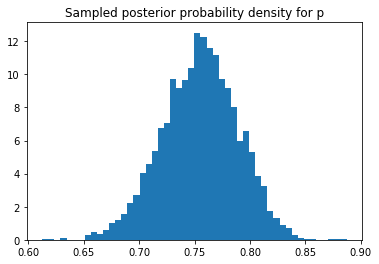

In [8]:
posterior_samples = stan_results.extract()
plt.hist(posterior_samples['p'], bins=50, density=True)
plt.title('Sampled posterior probability density for p')
print(
    "Posterior 95% confidence interval for p:",
    np.percentile(posterior_samples['p'], [2.5, 97.5]))
plt.show()

In [11]:
results_control = stan_model.sampling(data=eczema_data['control'])
print(results_control)

Inference for Stan model: anon_model_4822bea325d0250e03828b3bc1bb8bdd.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
p      0.47  1.0e-3   0.04   0.39   0.44   0.47    0.5   0.56   1723    1.0
lp__ -85.53    0.02   0.67 -87.52 -85.68 -85.25  -85.1 -85.06   1577    1.0

Samples were drawn using NUTS at Mon Oct  8 23:23:07 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [12]:
control_posterior_samples = results_control.extract()
print("95% confidence interval for p in the control group:",np.percentile(control_posterior_samples['p'], [2.5, 97.5]))

95% confidence interval for p in the control group: [0.38529994 0.55827184]


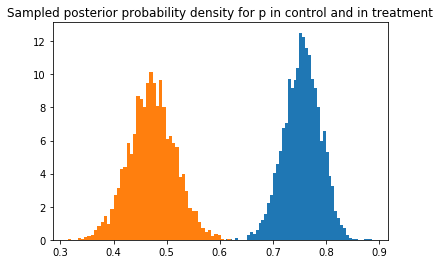

In [13]:
plt.hist(posterior_samples['p'], bins=50, density=True)
plt.hist(control_posterior_samples['p'], bins=50, density=True)
plt.title('Sampled posterior probability density for p in control and in treatment')
plt.show()

In [20]:
list_ = posterior_samples['p'] > control_posterior_samples['p']+0.19
print(sum(list_)/len(list_))

0.94925


In [21]:
N = 1000000
count = 0
for _ in range(N):
    choice = np.random.choice(4000, 2)
    if posterior_samples['p'][choice[0]] > control_posterior_samples['p'][choice[1]]+0.19:
        count += 1
print(count/N)

0.951015
